In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import torch
import torch.nn as nn
import numpy as np
import random
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split

# internal library imports

# internal library imports
from dataset import DebrisStateSeriesDataset
from model import ConvLSTM, ConvLSTMComplex, UNetLSTM
from train import TrainerSeries
from util.setting_utils import set_seed

In [2]:
# Set the random seed for multiple libraries to ensure repeatability

set_seed(42) 

In [3]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_small'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 1
seq_length = 6  # Specify the sequence length for the ConvLSTMUNet
array_size = 256

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)
hidden_dim = 64  # Hidden dimension of the ConvLSTM
kernel_size = (3, 3)  # Kernel size of the ConvLSTM

In [4]:
# # Data set up

# # Initialize dataset with scaling
# dataset = DebrisStateSeriesDataset(root_dir=root_dir, array_size=256, apply_scaling=True, sequence_length=seq_length)

# # Split dataset into train, validation, and test sets and create dataloaders
# train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)

# # Compute scaling factors based on the train dataset, but only if scaling is applied
# if dataset.apply_scaling:
#     train_dataset = train_loader.dataset.dataset 
#     dataset.compute_scaling_factors()

# Initialize dataset with scaling
dataset = DebrisStateSeriesDataset(root_dir=root_dir, array_size=array_size, apply_scaling=True, sequence_length=seq_length)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)

# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

print(dataset.scaling_factors)

Total dataset size: 2593
Train size: 1830, Validation size: 340, Test size: 423
(0.0, 280.02, 0.0, 30.0, 0.0, 8.0)


In [5]:
def compute_min_max(dataset):
    min_elevation = np.inf
    max_elevation = -np.inf
    min_velocity = np.inf
    max_velocity = -np.inf
    min_thickness = np.inf
    max_thickness = -np.inf

    for input_sequence_data, _ in dataset:
        elevation = input_sequence_data[:, 0, :, :].numpy()
        thickness = input_sequence_data[:, 1, :, :].numpy()
        velocity = input_sequence_data[:, 2, :, :].numpy()

        min_elevation = min(min_elevation, elevation.min())
        max_elevation = max(max_elevation, elevation.max())
        min_velocity = min(min_velocity, velocity.min())
        max_velocity = max(max_velocity, velocity.max())
        min_thickness = min(min_thickness, thickness.min())
        max_thickness = max(max_thickness, thickness.max())

    return min_elevation, max_elevation, min_velocity, max_velocity, min_thickness, max_thickness

In [6]:
# # Check the range of values in each dataset
# train_min_max = compute_min_max(train_loader.dataset)
# val_min_max = compute_min_max(val_loader.dataset)
# test_min_max = compute_min_max(test_loader.dataset)

# print("Train dataset range:")
# print("Elevation: [{:.2f}, {:.2f}]".format(*train_min_max[:2]))
# print("Velocity: [{:.2f}, {:.2f}]".format(*train_min_max[2:4]))
# print("Thickness: [{:.2f}, {:.2f}]".format(*train_min_max[4:]))

# print("\nValidation dataset range:")
# print("Elevation: [{:.2f}, {:.2f}]".format(*val_min_max[:2]))
# print("Velocity: [{:.2f}, {:.2f}]".format(*val_min_max[2:4]))
# print("Thickness: [{:.2f}, {:.2f}]".format(*val_min_max[4:]))

# print("\nTest dataset range:")
# print("Elevation: [{:.2f}, {:.2f}]".format(*test_min_max[:2]))
# print("Velocity: [{:.2f}, {:.2f}]".format(*test_min_max[2:4]))
# print("Thickness: [{:.2f}, {:.2f}]".format(*test_min_max[4:]))

In [7]:
# Model setup

models = [
    {'model': UNetLSTM(input_channels=in_channels, output_channels=out_channels), 'name': 'unet_lstm_test'}
]

Training on device: cuda.


Using 2 GPUs!
Training unet_lstm_test...
Epoch [1/1], Loss: 0.0666
Validation Loss: 0.0114
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/unet_lstm_test/model_epoch_1.pth
Losses saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/unet_lstm_test/losses_epoch_1.json
Loss plot saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/unet_lstm_test/loss_plot.png


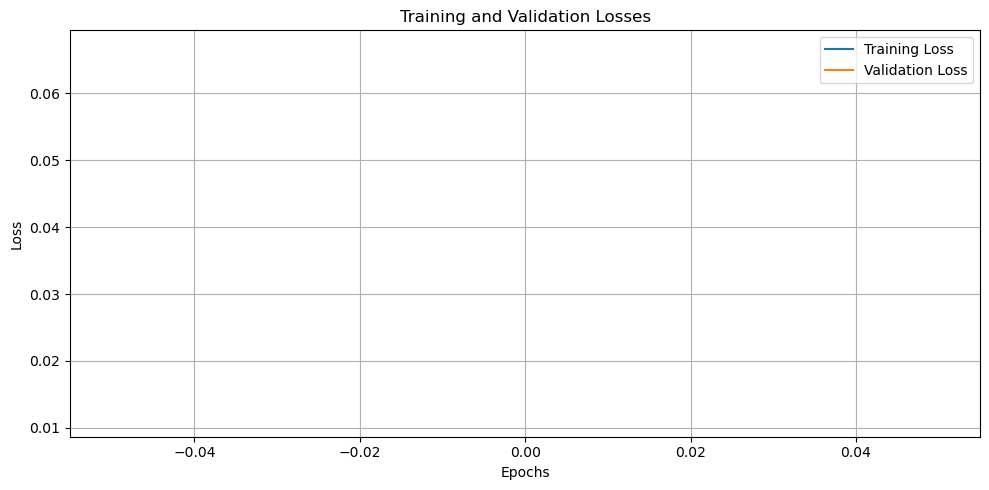

Finished training unet_lstm_test.


In [8]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Train each model
for model_info in models:
    
    model = model_info['model']

    # Check if multiple GPUs are available and wrap the model using nn.DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        # This will wrap the model for use with multiple GPUs
        model = torch.nn.DataParallel(model)
    
    # Move model to the appropriate device
    model.to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = TrainerSeries(model, optimizer, criterion, device, model_name=model_name, checkpoint_dir=checkpoint_dir)
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs, checkpoint_interval=5)
    
    print(f"Finished training {model_name}.")

Plotting losses...
Loss plot saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/unet_lstm_test/loss_plot.png


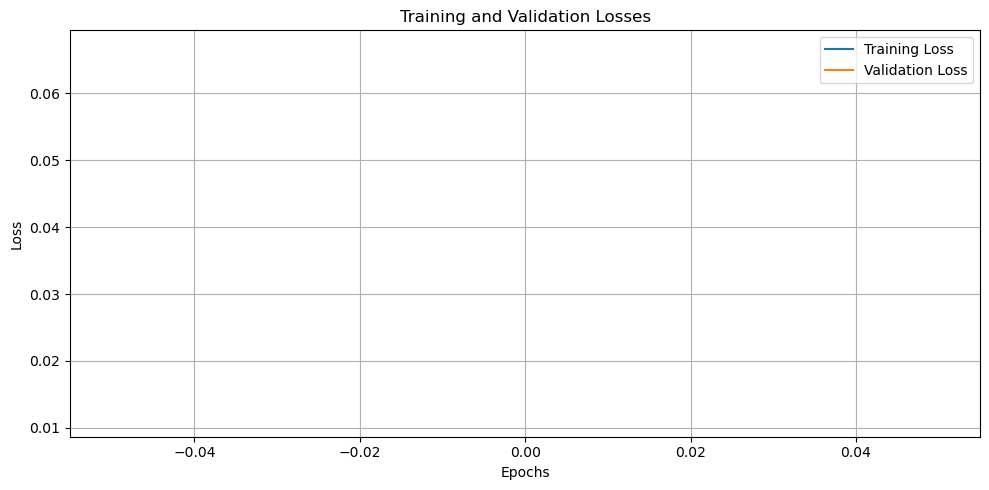

In [9]:
# Evaluate the model on the test set
print("Plotting losses...")
trainer.plot_losses()

In [10]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
trainer.test(test_loader)

Evaluating the model on the test set...
Test Loss: 0.0115


In [11]:
trainer.scaling_factors

(0.0, 280.02, 0.0, 30.0, 0.0, 8.0)

In [12]:
trainer.sequence_length

6

In [13]:
model_number = '00015'
state_number = 2
num_timesteps = 3


input_tensor = trainer.create_inference_input(root_dir=root_dir, 
                                              model_number=model_number, 
                                              state_number=state_number, 
                                              array_size=256)

In [14]:
input_tensor.shape

torch.Size([3, 256, 256])

In [17]:


inferred = trainer.infer(input_tensor, num_timesteps=num_timesteps)

In [22]:
# Get all keys from the dictionary
keys = inferred.keys()

# Print the keys
print(keys)

# If you want to use the keys as a list (for indexing or other list-specific operations), you can convert it to a list:
keys_list = list(keys)
print(keys_list)

dict_keys([1, 2, 3])
[1, 2, 3]


In [20]:
for key, value in inferred.items():
    print(f"Key: {key} -> Type of value: {type(value).__name__}")

Key: 1 -> Type of value: ndarray
Key: 2 -> Type of value: ndarray
Key: 3 -> Type of value: ndarray


In [26]:
inferred[keys_list[1]].shape

(2, 256, 256)

Plotting the expected vs predicted results...


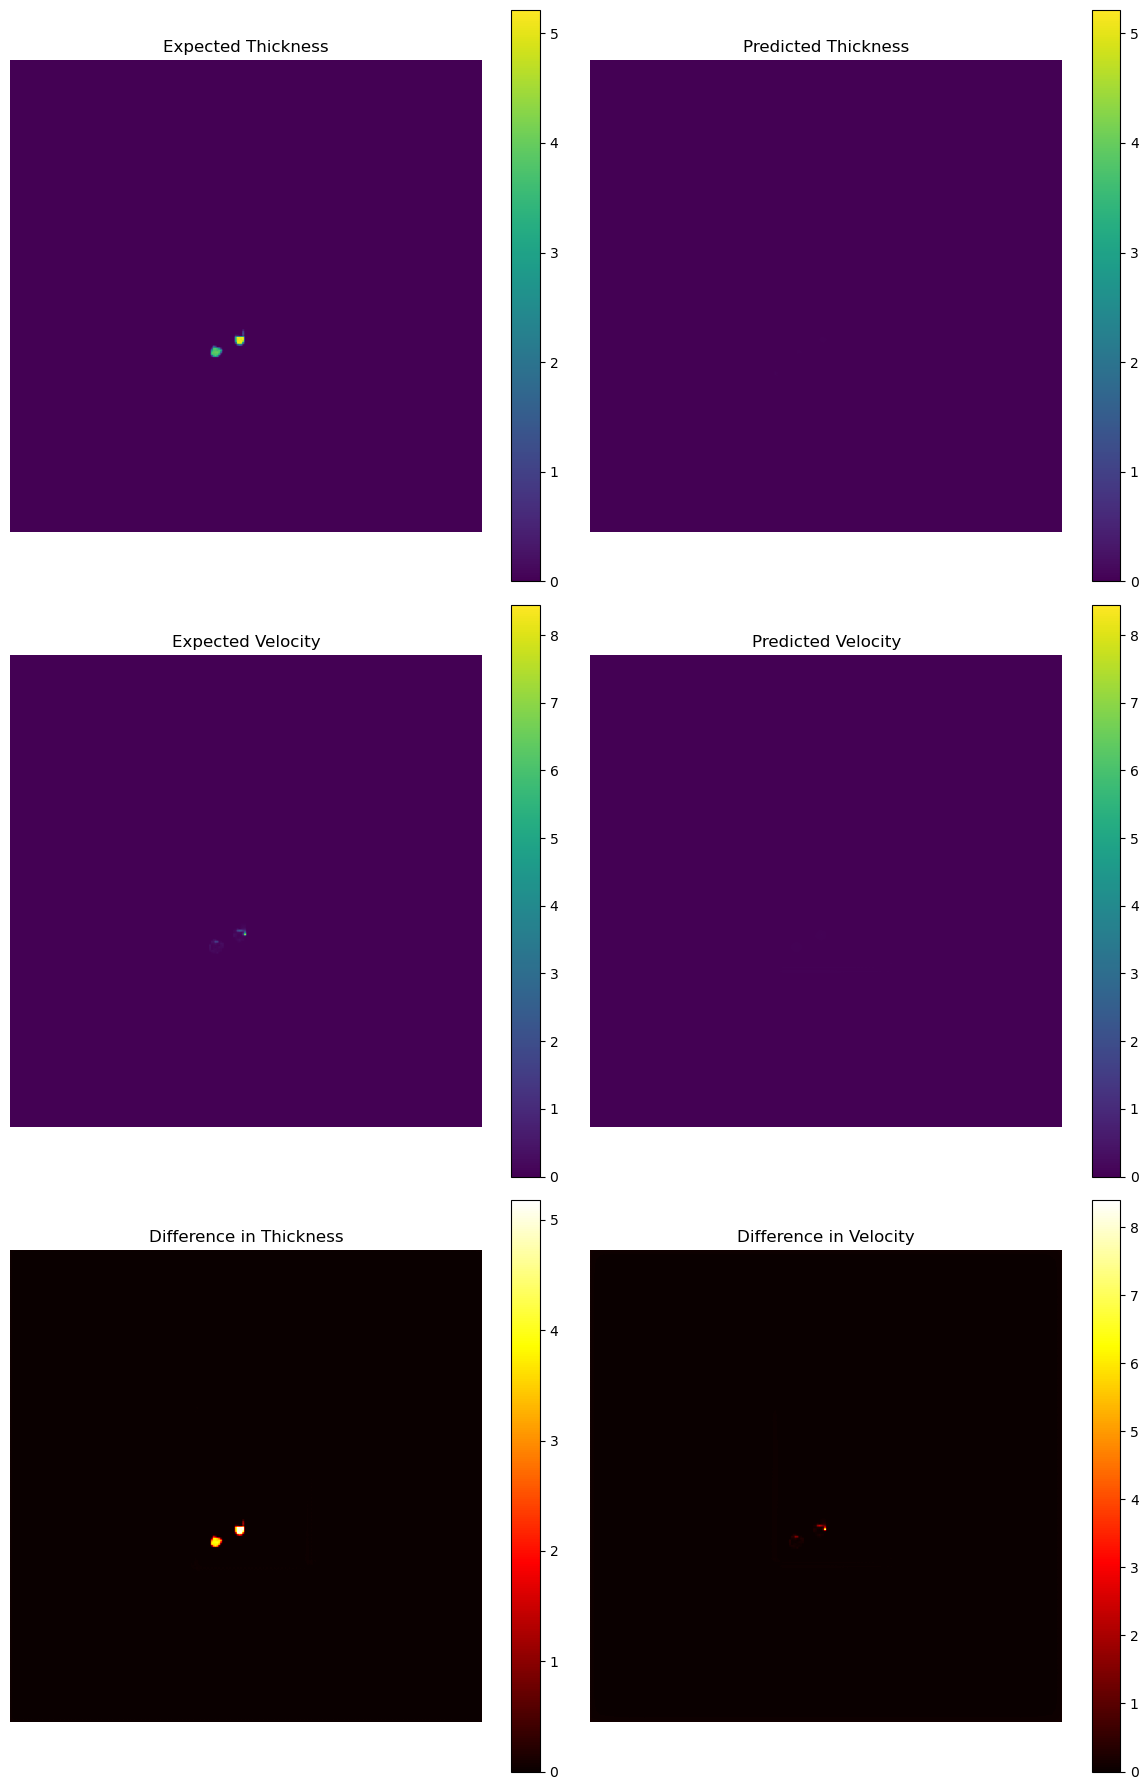

In [16]:
# Plot the expected vs predicted results
print("Plotting the expected vs predicted results...")
trainer.plot_predictions(test_loader, num_predictions=1)